In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

import pydotplus
from IPython.display import Image 

#  Прогнозирование задержек запуска ракет

In [32]:
launch_data = pd.read_excel('RocketLaunchDataCompleted.xlsx', engine='openpyxl')
launch_data.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Max Wind Speed,Visibility,Wind Speed at Launch Time,Hist Ave Max Wind Speed,Hist Ave Visibility,Sea Level Pressure,Hist Ave Sea Level Pressure,Day Length,Condition,Notes
0,NaN,1958-12-04,NaN,Cape Canaveral,NaN,NaN,75.0,68.0,71.00,NaN,...,16.0,15.0,NaN,NaN,NaN,30.22,NaN,10:26:00,Cloudy,NaN
1,NaN,1958-12-05,NaN,Cape Canaveral,NaN,NaN,78.0,70.0,73.39,NaN,...,14.0,10.0,NaN,NaN,NaN,30.2,NaN,10:26:00,Cloudy,NaN
2,Pioneer 3,1958-12-06,01:45:00,Cape Canaveral,Uncrewed,Y,73.0,0.0,60.21,62.0,...,15.0,10.0,11.0,NaN,NaN,30.25,NaN,10:25:00,Cloudy,NaN
3,NaN,1958-12-07,NaN,Cape Canaveral,NaN,NaN,76.0,57.0,66.04,NaN,...,10.0,10.0,NaN,NaN,NaN,30.28,NaN,10:25:00,Partly Cloudy,NaN
4,NaN,1958-12-08,NaN,Cape Canaveral,NaN,NaN,79.0,60.0,70.52,NaN,...,12.0,10.0,NaN,NaN,NaN,30.23,NaN,12:24:00,Partly Cloudy,NaN


В некоторых строках (помните, что строки представляют дни) отсутствуют данные о погоде или запуске. Из 300 строк некоторые столбцы содержат недостающие сведения:

In [10]:
launch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Name                          60 non-null     object        
 1   Date                          300 non-null    datetime64[ns]
 2   Time (East Coast)             59 non-null     object        
 3   Location                      300 non-null    object        
 4   Crewed or Uncrewed            60 non-null     object        
 5   Launched?                     60 non-null     object        
 6   High Temp                     299 non-null    float64       
 7   Low Temp                      299 non-null    float64       
 8   Ave Temp                      299 non-null    float64       
 9   Temp at Launch Time           59 non-null     float64       
 10  Hist High Temp                299 non-null    float64       
 11  Hist Low Temp                 29

Вы видите, что `Hist Ave Max Wind Speed`, `Hist Ave Visibility` и `Hist Ave Sea Level Pressure` не содержат данных.

Имеет смысл, что `Wind Speed at Launch Time`, `Temp at Launch Time`, `Launched`, `Crewed or Uncrewed`, `Time` и `Name` имеют только 60 значений, так как имеются данные о 60 запусках. Остальные представляют собой дни до и после запуска.

Вот несколько способов очистить данные:

- Строки, `у` которых нет `Y` в столбце `Launched`, не относятся к запуску ракету, потому сделайте отсутствующие значения `N`.
- Для строк, в которых отсутствуют сведения о том, был ли экипаж в ракете, установите значение "без экипажа". Запуск без экипажа более вероятен, потому что запусков с экипажем значительно меньше.
- Для отсутствующего направления ветра пометьте это как `unknown`.
- Для отсутствующих данных о погодных условиях предположите, что это был типичный день, и используйте `fair`.
- Для любых других данных используйте значение 0.

In [33]:
launch_data['Launched?'].fillna('N', inplace=True)
launch_data['Crewed or Uncrewed'].fillna('Uncrewed', inplace=True)
launch_data['Wind Direction'].fillna('unknown', inplace=True)
launch_data['Condition'].fillna('Fair', inplace=True)
launch_data.fillna(0, inplace=True)
launch_data.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Max Wind Speed,Visibility,Wind Speed at Launch Time,Hist Ave Max Wind Speed,Hist Ave Visibility,Sea Level Pressure,Hist Ave Sea Level Pressure,Day Length,Condition,Notes
0,0,1958-12-04,0,Cape Canaveral,Uncrewed,N,75.0,68.0,71.00,0.0,...,16.0,15.0,0.0,0.0,0.0,30.22,0.0,10:26:00,Cloudy,0
1,0,1958-12-05,0,Cape Canaveral,Uncrewed,N,78.0,70.0,73.39,0.0,...,14.0,10.0,0.0,0.0,0.0,30.2,0.0,10:26:00,Cloudy,0
2,Pioneer 3,1958-12-06,01:45:00,Cape Canaveral,Uncrewed,Y,73.0,0.0,60.21,62.0,...,15.0,10.0,11.0,0.0,0.0,30.25,0.0,10:25:00,Cloudy,0
3,0,1958-12-07,0,Cape Canaveral,Uncrewed,N,76.0,57.0,66.04,0.0,...,10.0,10.0,0.0,0.0,0.0,30.28,0.0,10:25:00,Partly Cloudy,0
4,0,1958-12-08,0,Cape Canaveral,Uncrewed,N,79.0,60.0,70.52,0.0,...,12.0,10.0,0.0,0.0,0.0,30.23,0.0,12:24:00,Partly Cloudy,0


Поскольку вычисления лучше всего подходят для числовых входных данных, преобразуйте весь текст в числа. В качестве примера мы будем использовать 1 , если ракета с экипажем, и 0, если ракета без экипажа.

In [12]:
## As part of the data cleaning process, we have to convert text data to numerical because computers understand only numbers
label_encoder = preprocessing.LabelEncoder()

# Three columns have categorical text info, and we convert them to numbers
launch_data['Crewed or Uncrewed'] = label_encoder.fit_transform(launch_data['Crewed or Uncrewed'])
launch_data['Wind Direction'] = label_encoder.fit_transform(launch_data['Wind Direction'])
launch_data['Condition'] = label_encoder.fit_transform(launch_data['Condition'])

In [13]:
launch_data.head()

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Max Wind Speed,Visibility,Wind Speed at Launch Time,Hist Ave Max Wind Speed,Hist Ave Visibility,Sea Level Pressure,Hist Ave Sea Level Pressure,Day Length,Condition,Notes
0,0,1958-12-04,0,Cape Canaveral,1,N,75.0,68.0,71.00,0.0,...,16.0,15.0,0.0,0.0,0.0,30.22,0.0,10:26:00,0,0
1,0,1958-12-05,0,Cape Canaveral,1,N,78.0,70.0,73.39,0.0,...,14.0,10.0,0.0,0.0,0.0,30.2,0.0,10:26:00,0,0
2,Pioneer 3,1958-12-06,01:45:00,Cape Canaveral,1,Y,73.0,0.0,60.21,62.0,...,15.0,10.0,11.0,0.0,0.0,30.25,0.0,10:25:00,0,0
3,0,1958-12-07,0,Cape Canaveral,1,N,76.0,57.0,66.04,0.0,...,10.0,10.0,0.0,0.0,0.0,30.28,0.0,10:25:00,6,0
4,0,1958-12-08,0,Cape Canaveral,1,N,79.0,60.0,70.52,0.0,...,12.0,10.0,0.0,0.0,0.0,30.23,0.0,12:24:00,6,0


Приступая к обучению модели машинного обучения, мы научим компьютер определять, какие компоненты данных нужно учитывать для составления прогнозов. Мы понимаем, что нам нужен прогноз модели для столбца "Запущено". Мы извлечем этот столбец и сохраним его в переменной в качестве списка `Y` и `N`.

Далее мы удалим некоторые из столбцов, которые не нужны для составления этого прогноза. Такие столбцы, как "Имя", обеспечивают дополнительный контекст для данных. Однако название запуска не является индикатором того, будет ли запуск отложен из-за погоды. В этом модуле основное внимание уделяется столбцам со скоростью ветра, условиями и осадками.

In [14]:
y = launch_data['Launched?']

# Removing the columns we are not interested in
launch_data.drop(['Name','Date',
                  'Time (East Coast)',
                  'Location','Launched?',
                  'Hist Ave Sea Level Pressure',
                  'Sea Level Pressure',
                  'Day Length',
                  'Notes',
                  'Hist Ave Visibility',
                  'Hist Ave Max Wind Speed'], axis=1, inplace=True)

# Saving the rest of the data as input data
X = launch_data

Теперь у нас две переменные. Выходные данные представлены в `y`, а входные — в `X`. В столбце в только что созданной переменной `X` содержатся обзорные сведения о входных данных:

In [15]:
X.columns

Index(['Crewed or Uncrewed', 'High Temp', 'Low Temp', 'Ave Temp',
       'Temp at Launch Time', 'Hist High Temp', 'Hist Low Temp',
       'Hist Ave Temp', 'Percipitation at Launch Time',
       'Hist Ave Percipitation', 'Wind Direction', 'Max Wind Speed',
       'Visibility', 'Wind Speed at Launch Time', 'Condition'],
      dtype='object')

Вы выбрали, какие столбцы нужно использовать, чтобы спрогнозировать, будет ли ракета запущена с учетом определенных погодных условий. Теперь необходимо выбрать алгоритмы для создания нашей модели. Вспомним материал <a href="https://docs.microsoft.com/ru-ru/azure/machine-learning/algorithm-cheat-sheet">памятки по алгоритму машинного обучения</a>.

![](./microsoft/media/algorithm-cheat-sheet.png)

Вспомните свой вопрос: _Можно ли спрогнозировать вероятность запуска с учетом конкретных погодных условий?_ У этого вопроса два ответа. Ракета будет запущена: **да** или **нет**. Этот вопрос считается проблемой _двухклассовой классификации_.

В этой категории алгоритмов доступно множество алгоритмов на выбор. В этом случае вы работаете с двухклассовым деревом принятия решений. Визуализация результатов дерева принятия решений дает аналитическую информацию, которая поможет в будущем осуществлять итеративный сбор, очистку данных и операции с ними.

## Создание модели машинного обучения в Python

С помощью библиотеки `scikit-learn` легко создать модель машинного обучения, которая вам нужна для выполнения этого упражнения.

In [17]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5)

Давайте рассмотрим <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree%20classifier#sklearn.tree.DecisionTreeClassifier">документацию для классификатора дерева принятия решений</a>  и важность указанных здесь параметров. Мы указали два параметра: `random_state` и `max_depth`.

Параметр `random_state` будет использоваться для большинства алгоритмов машинного обучения. Он управляет случайностью алгоритма. Когда вы используете это средство оценки для разделения данных на обучающие и тестовые данные, предоставленное здесь начальное значение диктует произвольность разделения. В следующем уроке приводится больше сведений о разделении данных.

Параметр `max_depth` — это зависящий от дерева параметр, который позволяет определить объем выходных данных модели. В данном случае он вряд ли будет достаточно информативным и вряд ли сможет использоваться для оценки всех возможных вероятностей погодных условий и их влияния на вероятность запуска ракеты. Глубина не может превышать 5, чтобы ограничить объем получаемой информации наиболее важными для выходных данных практическими сведениями.

## Разделение данных на обучающий и проверочный наборы

Следующий шаг — разделение данных на обучающие и тестовые. Предоставление классификатору машинного обучения всех ваших данных позволит ему только сообщить, какие данные у вас имеются. Это не позволит делать точные прогнозы.

### Зачем разделять данные?
Один из способов объяснить важность разделения данных — сравнить их с экзаменом, который вам, возможно, предстоит сдать. Допустим, вы проходите формальный курс обучения. На протяжении всего курса вам показывают примеры задач и говорят ответы на них. Так происходит на лекциях, при выполнении домашней работы и на практических экзаменах.

Представьте себе курс, на котором преподаватель дал вам экзаменационные задания и ответы на них (ключи) за день до экзамена. Могли бы вы сдать тест на отлично? Да!

Поняли бы вы, усвоили вы понятия или нет? Нет. Скорее всего, вы выучили ответы на вопросы теста, но не усвоили понятия, на тестирование которых нацелен экзамен.

Если вы действительно хотите научиться, нужно практиковаться в решении задач, на которые вам дали ответы. Когда вы будете уверенно решать эти задачи, переходите к задачам, ответы на которые вы еще не знаете. Вот что делает классификатор, чтобы "научиться".

### Разделение данных
Необходимо разделить данные на четыре новые переменные. У вас уже есть переменные X и y, представляющие ваши входные и выходные данные. Пришло время разделить их на обучающие и проверочные данные.

Используя библиотеку `scikit-learn` и доступную в классификаторе функцию разделения, можно получить произвольную выборку `X` и `y`, которые совпадают по порядку. Если данные были разделены не произвольно, а, например, первые 80% строк были взяты в качестве обучающих данных, а остальные — в качестве проверочных, возникнут проблемы.

Предположим, например, что данные сортируются по дате. Если первые 240 строк были взяты в качестве обучающих данных, вы будете обучать свою модель, используя данные до 1999 года. Это проблема, потому что со временем датчики могли измениться. Анализ исключительно старых данных — не лучший способ принимать решения, связанные с новыми технологиями.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

Этот код произвольно разделяет данные на четыре группы: `X_train`, `X_test`, `y_train` и `y_test`. Используя функцию `train_test_split` библиотеки `scikit-learn`, можно задать четыре важных параметра:

- Вводные данные: `X` — все столбцы, которые требуется использовать для прогнозирования запуска.
- Выходные данные: `y` — результат каждой строки (была ли запущена ракета или нет).
- Размер теста: 0.2 — обучение модели с использованием 80% данных и тестирование с использованием оставшихся 20% является типичным подходом в сфере обработки и анализа данных.
- Случайное состояние: 99 — случайное начальное значение, которое изменит произвольный характер выбора данных.

Можно вернуться и изменить размер теста и произвольное состояние, чтобы поэкспериментировать и с другими вариантами.

## Адаптация модели
Следующий этап жизненного цикла обработки и анализа данных — адаптировать модель к обучающим данным. По сути, адаптация — это обучение модели. Для описания этого процесса мы использовали пример с вишней. Человек адаптировался, когда приносил вишню и ему говорили, что это. Для адаптации модели нужно вызвать `fit()` в классификаторе машинного обучения и передать данные `X_train` и `y_train`.

Адаптацию модели можно сравнить со сдачей практического экзамена, когда у вас есть доступ к ответам, чтобы гарантировать освоение всех понятий.

In [19]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

## Тестирование модели
Тестирование модели также значительно упрощают библиотеки, которые мы импортировали. Тестирование модели похоже на сдачу экзамена. Вы предоставите `X_test` (20% вводных данных, зарезервированных для тестирования) функции `predict()` классификатора. Эта функция возвращает список `Y` и `N`, представляющий, что, по мнению модели, произойдет, если бы была предпринята попытка запуска ракеты в определенных погодных условиях

In [20]:
y_pred = tree_model.predict(X_test)
print(y_pred)

['N' 'N' 'N' 'Y' 'N' 'N' 'N' 'N' 'Y' 'Y' 'N' 'Y' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'Y' 'Y' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'Y' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'Y' 'N' 'N' 'N' 'Y' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'Y']


Сколько `Y` у вас получилось? Соответствуют ли прогнозы введенным данным? Ответить на эти вопросы без дополнительного рассмотрения невозможно, но пока очевидно, что выходные данные содержат ~9 ответов `Y` из 60 введенных значений. Около 20% всех данных дали `Y`. Эта доля составляет примерно 15% прогнозируемых данных, так что это относительно близко.

Простое сравнение процента данных, которые привели к запуску Y, позволяет проверить правильность модели. Однако еще более полезно это сравнение для оценки модели.

## Оценка модели
Как и в случае с экзаменом, обучение можно оценить с помощью оценки. Существует однострочная функция, которую можно вызвать, чтобы узнать, насколько точно модель прогнозировала вероятность запуска.

In [22]:
tree_model.score(X_test, y_test)

0.9833333333333333

С помощью функции `score()` вы передаете входные `X_test` и выходные `y_test` данные для "оценки" модели. Чем выше оценка, тем точнее наша модель может прогнозировать результат запуска ракеты на основе метеорологических данных.

В этом примере точность модели оценивается на уровне 98,3 %, что является хорошим результатом. По сути, это даже слишком хорошо, учитывая, как мало операций с данными (в том числе по очистке) мы выполнили, и известные проблемы с данными.

Возможно, у нас были лучшие данные и мы хорошо обучили свою модель, сделав ее максимально точной. Но возможно, что такой показатель точности указывает на то, что мы хорошо угадываем "искусственные" данные, и полагаться на этот результат в реальной жизни нельзя. В контексте при использовании классификатора дерева принятия решений стандартным является показатель точности 70% (при выполнении впервые).

Как гарантировать, что эта оценка справедливо отражает точность нашей модели?

Во-первых, можно попросить эксперта заполнить данные `Y` и `N` для дней без запуска, вместо того чтобы просто угадывать `N`. Например, вероятность того, что день до или день после запуска также отлично подходит для запуска, скорее всего, выше, чем мы представили в этих данных.

## Визуализация модели машинного обучения

Одним из преимуществ использования классификатора дерева принятия решений является наличие визуализации, которую можно использовать для лучшего понимания процесса принятия решений моделью. С помощью `graphviz` и `pydotplus` легко увидеть, как принимается решение. В будущих итерациях можно увидеть, как меняются решения.

### Создание визуального дерева
Чтобы создать визуальное представление модели, будет создана функция, которая принимает в качестве параметров следующее:

- Данные: `tree` — модель машинного обучения
- Столбцы: `feature_names` — список столбцов во вводных данных
- Вывод: `class_names` — список вариантов для классификации (в данном случае "да" или "нет")
- Имя файла: `png_file_to_save` — имя файла, в котором требуется сохранить визуализацию

Вы вызовете функцию `export_graphviz()` библиотеки `scikit-learn`, а затем вернете визуальное представление графика, которое вам предоставляет `scikit-learn`.

In [23]:
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names,class_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, class_names=class_names,
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    return Image(graph.create_png())

Вызвать эту функцию достаточно просто:

- Данные: `tree_model` — модель, которую вы обучили и протестировали ранее
- Столбцы: `X.columns.values` — список столбцов во входных данных
- Выходные данные: `[yes, no]` — два возможных результата
- Имя файла: `decision_tree.png` — имя файла, в котором требуется сохранить изображение

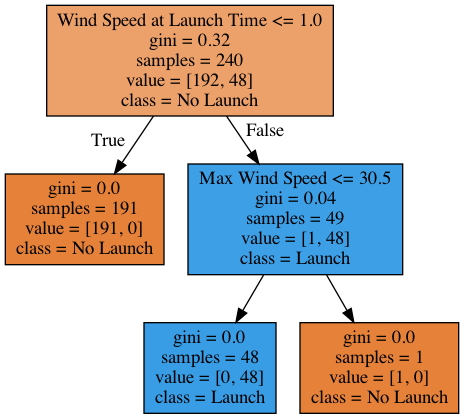

In [25]:
tree_graph_to_png(tree=tree_model, feature_names=X.columns.values,
                  class_names=['No Launch','Launch'],
                  png_file_to_save='decision-tree.png')

Для пользователей MacOs возможно понадобится дополнительная установка пакета `graphviz` 

```bash
brew install graphviz
```

В целом, если рассматривать набор данных, у нас есть 240 примеров:

- 192 — запуск не состоялся
- 48 — запуск состоялся

Такой результат объясняется нашей стратегией очистки данных: мы допустили, что все непомеченные дни — это дни, когда запусков не было.

Используя новые метки, можно сказать: "Если скорость ветра менее 1,0, то в 191 из 240 случаев запуск в определенный день был невозможен". Этот результат может показаться странным, но с учетом имеющихся данных он верен. Вот доказательство. Мы составили график дней с запусками и без запусков для дней, когда скорость ветра во время запуска была меньше или равна 1, прежде чем опустить столбец ранее в этой записной книжке. Он показывает, что практически все время запусков не было:

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

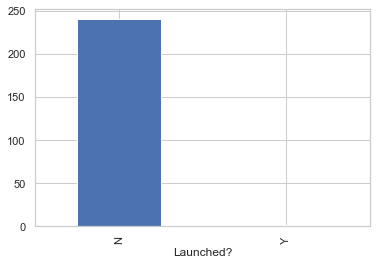

In [59]:
launch_data[launch_data['Wind Speed at Launch Time'] <= 1] \
                         .groupby('Launched?').size().plot(kind='bar');

## Общие сведения о визуализации
Это простое дерево показывает, что самая важная характеристика данных — `Wind Speed at Launch Time`. Если скорость ветра была меньше 1,0, то 191 из 240 примеров были правильно определены как дни без запусков. Мы видим, что в 191 из этих примеров для правильного прогнозирования результата требовалось только, чтобы значение Wind Speed at Launch Time было меньше 1,0. Если значение было больше 1,0, требовалась дополнительная информация.

Эти аналитические сведения не отличались полезностью. Ранее мы задали все пустые значения равными 0. Кроме того, мы знаем, что многие значения, связанные с временем запуска, были равны 0, так как 60% наших данных не были связаны с фактическим запуском или попыткой запуска.

Если продолжить анализировать дерево, мы увидим, что `Max Wind Speed` — это следующая самая важная характеристика данных. Здесь вы видите, что в остальные 49 дней, когда максимальная скорость ветра была менее 30,5, в 48 случаях был правильно спрогнозирован запуск, а в одном из них — отсутствие запуска.

Эти данные могут стать более интересными в контексте реальной жизни. Существует только один день, на который планировался запуск, и значение `Max Wind Speed` было больше 30,5. Это было 27 мая 2020 г. Затем запуск Space X Dragon был перенесен на 30 мая 2020 г. Вот доказательство.

In [60]:
launch_data[(launch_data['Wind Speed at Launch Time'] > 1) 
                          & (launch_data['Max Wind Speed'] > 30.5)]

,Name,Date,Time (East Coast),Location,Crewed or Uncrewed,Launched?,High Temp,Low Temp,Ave Temp,Temp at Launch Time,...,Max Wind Speed,Visibility,Wind Speed at Launch Time,Hist Ave Max Wind Speed,Hist Ave Visibility,Sea Level Pressure,Hist Ave Sea Level Pressure,Day Length,Condition,Notes
292,Space X Dragon,2020-05-27,16:33:00,Cape Canaveral,Crewed,N,86.0,70.0,75.02,74.0,...,32.0,10.0,25.0,0.0,0.0,29.98,0.0,13:44:00,Heavy T-Storm,0


## Улучшение результатов

Одно из возможных усовершенствований заключается в определении взаимосвязи между `Max Wind Speed` и `Wind Speed at Launch Time` для строк, содержащих эту информацию. Затем, вместо того чтобы делать `Wind Speed at Launch Time` равным 0 для дней, когда не было запуска, его можно было бы использовать для прогнозирования происходящего в стандартное время запуска. Это изменение могло бы способствовать более точному представлению данных.

Наконец, пора протестировать вашу модель, используя данные, которые никогда не были обнаружены в вашем наборе данных.

30 июля 2020 г. в 7:50 утра по восточному времени НАСА запустила исследовательский корабль Perseverance на Марс с мыса Канаверал.

Соберите входные данные для модели:

- Управляемый или неуправляемый
- Высокая температура
- Низкая температура
- Средняя температура
- Температура во время запуска
- Самая высокая температура за прошлые периоды
- Самая низкая температура за прошлые периоды
- Средняя температура за прошлые периоды
- Осадки во время запуска
- Среднее количество осадков за прошлые периоды
- Направление ветра
- Максимальная скорость ветра
- Видимость
- Скорость ветра во время запуска
- Средняя максимальная скорость ветра за прошлые периоды
- Средняя видимость за прошлые периоды
- Условие

Эту информацию можно найти на большинстве метеорологических сайтов. Запомните, что можно использовать исключительно числовые данные.

В следующем примере используются гипотетические данные:

In [61]:
# ['Crewed or Uncrewed', 'High Temp', 'Low Temp', 'Ave Temp',
#        'Temp at Launch Time', 'Hist High Temp', 'Hist Low Temp',
#        'Hist Ave Temp', 'Precipitation at Launch Time',
#        'Hist Ave Precipitation', 'Wind Direction', 'Max Wind Speed',
#        'Visibility', 'Wind Speed at Launch Time', 'Hist Ave Max Wind Speed',
#        'Hist Ave Visibility', 'Condition']

data_input = [1., 75., 68., 71., 0., 75., 55., 65., 0., 0.08, 0., 16., 15., 0., 0.]

tree_model.predict([data_input])

array(['N'], dtype=object)

Кроме того, можно использовать прогнозы погоды в сочетании с моделью машинного обучения, чтобы проверить, можно ли спрогнозировать задержку еще до начала запуска!